<a href="https://colab.research.google.com/github/NurlanNKZ/heat-equation-experiments/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Num_exper_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy matplotlib -q

import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:00
Using device: cuda


# Новое

### **Ввод параметров**

In [ ]:
# Параметры задачи
s = 2             # размерность (пространство R^2)
r = 4             # степень гладкости
theta = 1.1       # второй индекс в пространстве Бесова
L = 1.0           # размер области по каждой координате
n_max = 6         # максимальное значение n
t_list = [0.0, 0.001, 0.01, 0.1]  # времена, на которых считаем решение
scale_factor = 1.0               # масштаб, если нужно усилить амплитуду
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Контроль
print(f"device = {device}")
print(f"Будем считать при параметрах: r = {r}, theta = {theta}, s = {s}")

device = cuda
Будем считать при параметрах: r = 4, theta = 1.1, s = 2


### **Построение множества частот $Q_n​ ⊂Z^2$ и определение коэффициентов Фурье $\hat{f}(m)$**

In [ ]:
def get_k(m):
    # m — тензор размерности (N, 2)
    abs_m = torch.maximum(torch.abs(m), torch.tensor([1], device=device))
    return torch.ceil(torch.log2(abs_m.float())).max(dim=1).values.int()

def build_Qn(n):
    grid_range = torch.arange(-2**n, 2**n + 1, device=device)
    m1, m2 = torch.meshgrid(grid_range, grid_range, indexing='ij')
    M = torch.stack((m1, m2), dim=-1).reshape(-1, 2)
    M = M[torch.any(torch.abs(M) > 1, dim=1)]  # удалим (0,0), (±1,0), (0,±1)
    return M

def compute_hat_f(M, r, s, theta):
    k_vals = get_k(M)
    coeffs = 2 ** (-k_vals * (r - s/2 + 1/theta))
    return coeffs.to(torch.complex64), k_vals

# Пример использования
n = 4
M = build_Qn(n)                          # Частоты
f_hat, k_vals = compute_hat_f(M, r, s, theta)  # Коэффициенты Фурье
print(f"Размер множества Q_{n}: {M.shape[0]}")

Размер множества Q_4: 1080


### **Построение пространственной сетки и вычисление точного решения $𝑢(𝑡,𝑥)$**

In [ ]:
# Сетка в [0, 1]^2
grid_points = 64  # число точек по каждой координате
x_vals = torch.linspace(0, L, grid_points, device=device)
X, Y = torch.meshgrid(x_vals, x_vals, indexing='ij')
Z = torch.stack((X, Y), dim=-1)  # форма (grid_points, grid_points, 2)

def solution(M, f_hat, Z, t):
    """
    Вычисляет точное комплексное решение u(t,x)
    """
    phase = torch.einsum('ij,xyj->ixy', M.float(), Z)
    decay = torch.exp(-4 * np.pi**2 * (M.float()**2).sum(dim=1) * t)
    terms = f_hat * decay  # (N,) — амплитуды

    # Строим комплексную экспоненту
    cos_part = torch.cos(2 * np.pi * phase)
    sin_part = torch.sin(2 * np.pi * phase)
    real = torch.sum(cos_part * terms.real[:, None, None] - sin_part * terms.imag[:, None, None], dim=0)
    imag = torch.sum(sin_part * terms.real[:, None, None] + cos_part * terms.imag[:, None, None], dim=0)

    return torch.complex(real, imag)  # форма (grid_points, grid_points)


Пример вычисления точного решения

In [ ]:
# Вычисление точного решения при всех t
u_exact_list = []
for t_val in t_list:
    u_t = solution(M, f_hat, Z, t_val).cpu()
    u_exact_list.append(u_t)
    print(f"u(t={t_val}) рассчитано, макс: {u_t.abs().max():.2e}")


u(t=0.0) рассчитано, макс: 1.39e+00
u(t=0.001) рассчитано, макс: 9.95e-01
u(t=0.01) рассчитано, макс: 1.42e-01
u(t=0.1) рассчитано, макс: 3.83e-08


Построим графики точного решения

In [ ]:
!pip install plotly
import plotly.graph_objects as go

def plotly_surface(U, t_val, title_prefix="Точное решение"):
    """
    Вращаемый 3D-график |u(x,y,t)| с помощью plotly
    """
    #Z_plot = U.abs().cpu().numpy()
    Z_plot = U.real.cpu().numpy()
    #Z_plot = U.jmag.cpu().numpy()
    x_vals = X[:, 0].cpu().numpy()
    y_vals = Y[0, :].cpu().numpy()

    fig = go.Figure(data=[
        go.Surface(z=Z_plot, x=x_vals, y=y_vals, colorscale='Viridis')
    ])

    fig.update_layout(
        title=f"{title_prefix} |u(x,y,t={t_val})|",
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="|u|",
            aspectratio=dict(x=1, y=1, z=0.5),
        ),
        width=700,
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


In [ ]:
plotly_surface(u_exact_list[1], t_val=t_list[1])

### **Построение приближённого агрегата $𝜑_𝑁(𝑡,𝑥;\tilde{𝑐})$**

In [ ]:
def aggregate(M, coeffs, Z, t):
    """
    Вычисляет приближённое решение (агрегат) phi_N(t, x; coeffs)
    """
    phase = torch.einsum('ij,xyj->ixy', M.float(), Z)
    decay = torch.exp(-4 * np.pi**2 * (M.float()**2).sum(dim=1) * t)
    terms = coeffs * decay

    cos_part = torch.cos(2 * np.pi * phase)
    sin_part = torch.sin(2 * np.pi * phase)

    real = torch.sum(cos_part * terms.real[:, None, None] - sin_part * terms.imag[:, None, None], dim=0)
    imag = torch.sum(sin_part * terms.real[:, None, None] + cos_part * terms.imag[:, None, None], dim=0)

    return torch.complex(real, imag)

Пример использования:

In [ ]:
# Без шума
phi_exact = aggregate(M, f_hat, Z, t=0.01).cpu()

# С шумом
eps_n = 1e-4
noise_real = torch.rand_like(f_hat.real) * eps_n
noise_imag = torch.rand_like(f_hat.imag) * eps_n
tilde_c = f_hat + torch.complex(noise_real, noise_imag)

phi_noisy = aggregate(M, tilde_c, Z, t=0.01).cpu()

 Визуализация: интерактивный 3D-график для $𝜑_𝑁$​

In [ ]:
def plot_aggregate_surface(U, t_val, title="Агрегат φ_N(t,x)", zlabel="|φ_N|"):
    """
    Вращаемый график модуля агрегата φ_N(t,x)
    """
    #Z = U.abs().cpu().numpy()
    Z =U.real.cpu().numpy()
    #Z =U.jmag.cpu().numpy()
    x_vals = X[:, 0].cpu().numpy()
    y_vals = Y[0, :].cpu().numpy()

    fig = go.Figure(data=[
        go.Surface(z=Z, x=x_vals, y=y_vals, colorscale='Viridis')
    ])

    fig.update_layout(
        title=f"{title}, t = {t_val}",
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title=zlabel,
            aspectratio=dict(x=1, y=1, z=0.5)
        ),
        width=750,
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

In [ ]:
plot_aggregate_surface(phi_exact, t_val, title="Агрегат с точными коэффициентами")
plot_aggregate_surface(phi_noisy, t_val, title="Агрегат с шумом")

### **Строим модульную структуру**

Добавление шума к коэффициентам

In [ ]:
def add_noise(c_exact, eps_n, mode="random", eta_n=None):
    """
    Возвращает приближённые коэффициенты c̃_m = c_m + шум
    mode: "random", "systematic", "eta_scaled"
    """
    if mode == "random":
        noise_real = torch.rand_like(c_exact.real) * eps_n
        noise_imag = torch.rand_like(c_exact.imag) * eps_n
        noise = torch.complex(noise_real, noise_imag)
        return c_exact + noise

    elif mode == "systematic":
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_n),
            torch.full_like(c_exact.imag, eps_n)
        )
        return c_exact + noise

    elif mode == "eta_scaled":
        if eta_n is None:
            raise ValueError("eta_n must be specified for eta_scaled noise")
        eps_eta = eps_n * eta_n
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_eta),
            torch.full_like(c_exact.imag, eps_eta)
        )
        return c_exact + noise

    else:
        raise ValueError(f"Unknown noise mode: {mode}")


Вычисление погрешностей

In [ ]:
def compute_errors(u_exact, u_approx):
    """
    Возвращает L2 и max нормы разности между решением и приближением
    """
    diff = u_exact - u_approx
    l2 = torch.sqrt((diff * torch.conj(diff)).real.mean()).item()
    max_err = torch.abs(diff).max().item()
    return l2, max_err


Пример использования

In [ ]:
t_val = 0.01
eps_n = 1e-4
eta_n = 10

# Точное решение
u_ref = solution(M, f_hat, Z, t_val).cpu()

# Случайный шум
c_rand = add_noise(f_hat, eps_n, mode="random")
u_rand = aggregate(M, c_rand, Z, t_val).cpu()

# Систематический шум
c_sys = add_noise(f_hat, eps_n, mode="systematic")
u_sys = aggregate(M, c_sys, Z, t_val).cpu()

# Шум с eta
c_eta = add_noise(f_hat, eps_n, mode="eta_scaled", eta_n=eta_n)
u_eta = aggregate(M, c_eta, Z, t_val).cpu()

# Погрешности
e_rand = compute_errors(u_ref, u_rand)
e_sys  = compute_errors(u_ref, u_sys)
e_eta  = compute_errors(u_ref, u_eta)

print("Случайный шум:", e_rand)
print("Систематический шум:", e_sys)
print("Шум с eta_n:", e_eta)


Случайный шум: (5.835119736730121e-05, 0.00020822240912821144)
Систематический шум: (8.526472811354324e-05, 0.0003459700383245945)
Шум с eta_n: (0.0008526358287781477, 0.0034595741890370846)


 визуализации погрешности

In [ ]:
def plot_error_surface(u_exact, u_approx, t_val, title="Погрешность |u - φ_N|"):
    """
    Вращаемый график модуля погрешности между точным и приближённым решением
    """
    error = (u_exact - u_approx).abs().cpu().numpy()
    x_vals = X[:, 0].cpu().numpy()
    y_vals = Y[0, :].cpu().numpy()

    fig = go.Figure(data=[
        go.Surface(z=error, x=x_vals, y=y_vals, colorscale='Inferno')
    ])

    fig.update_layout(
        title=f"{title}, t = {t_val}",
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="Погрешность",
            aspectratio=dict(x=1, y=1, z=0.5)
        ),
        width=750,
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

Пример использования:

In [ ]:
plot_error_surface(u_ref, phi_exact, t_val, title="Погрешность при точных коэффициентах")
plot_error_surface(u_ref, phi_noisy, t_val, title="Погрешность при шуме")

In [ ]:
from plotly.subplots import make_subplots

def plot_comparison_surfaces(u_exact, phi_exact, phi_noisy, t_val):
    """
    Строит 3D графики: φ_N (точное), φ_N (шум), и |u - φ_N| на одном полотне
    """
    # Данные
    x_vals = X[:, 0].cpu().numpy()
    y_vals = Y[0, :].cpu().numpy()
    z1 = phi_exact.abs().cpu().numpy()
    z2 = phi_noisy.abs().cpu().numpy()
    z3 = (u_exact - phi_noisy).abs().cpu().numpy()

    fig = make_subplots(rows=1, cols=3,
                        specs=[[{'type': 'surface'}]*3],
                        subplot_titles=[
                            "Точное приближение",
                            "С шумом",
                            "Погрешность |u - φ_N|"
                        ])

    fig.add_trace(go.Surface(z=z1, x=x_vals, y=y_vals, colorscale='Viridis', showscale=False),
                  row=1, col=1)
    fig.add_trace(go.Surface(z=z2, x=x_vals, y=y_vals, colorscale='Viridis', showscale=False),
                  row=1, col=2)
    fig.add_trace(go.Surface(z=z3, x=x_vals, y=y_vals, colorscale='Inferno', showscale=True),
                  row=1, col=3)

    fig.update_layout(
        title_text=f"Сравнение агрегатов и ошибки при t = {t_val}",
        width=1400,
        height=500,
        margin=dict(l=0, r=0, b=0, t=40),
        scene=dict(aspectratio=dict(x=1, y=1, z=0.5)),
    )

    fig.show()


1μ=1 μ unit = $10^{-6}$

In [ ]:
plot_comparison_surfaces(u_ref, phi_exact, phi_noisy, t_val)

### **Переходим к главному вопросу — сравнение агрегатов при:**

* 📘 точной информации: $c_𝑚=\hat{f}(𝑚)$
* 🟡 шуме уровня $𝜀_n$: $c_𝑚=\hat{f}(m)+𝜀_n⋅шум_𝑚$
* 🔴 шуме уровня $𝜀_n⋅𝜂_n$: $c_𝑚=\hat{f}(𝑚)+𝜀_n⋅𝜂_n⋅шум_𝑚$

🧠 **Цель:**
Показать, что:

* 🔹 При $𝜀_n$ — агрегат устойчив, порядок сходимости сохраняется.
* 🔸 При $𝜀_n⋅𝜂_n$ — ошибка возрастает, сходимость ломается.



Цикл по n и t, вычисление всех ошибок

In [ ]:
results = []

for n in range(2, 7):
    M = build_Qn(n)
    f_hat, _ = compute_hat_f(M, r, s, theta)

    eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
    eta_n = (n + 1)**1.5  # медленно растёт — можно менять

    for t_val in t_list:
        u_ref = solution(M, f_hat, Z, t_val).cpu()

        # phi_N при точных коэффах
        phi_exact = aggregate(M, f_hat, Z, t_val).cpu()

        # при eps_n
        c_eps = add_noise(f_hat, eps_n, mode="random")
        phi_eps = aggregate(M, c_eps, Z, t_val).cpu()

        # при eps_n * eta_n
        c_eta = add_noise(f_hat, eps_n, mode="eta_scaled", eta_n=eta_n)
        phi_eta = aggregate(M, c_eta, Z, t_val).cpu()

        # ошибки
        err_exact, _ = compute_errors(u_ref, phi_exact)
        err_eps, _ = compute_errors(u_ref, phi_eps)
        err_eta, _ = compute_errors(u_ref, phi_eta)

        results.append({
            "n": n,
            "N": M.shape[0],
            "t": t_val,
            "eps_n": eps_n,
            "eta_n": eta_n,
            "L2_exact": err_exact,
            "L2_eps": err_eps,
            "L2_eta": err_eta
        })


Построим график с логарифмами:

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



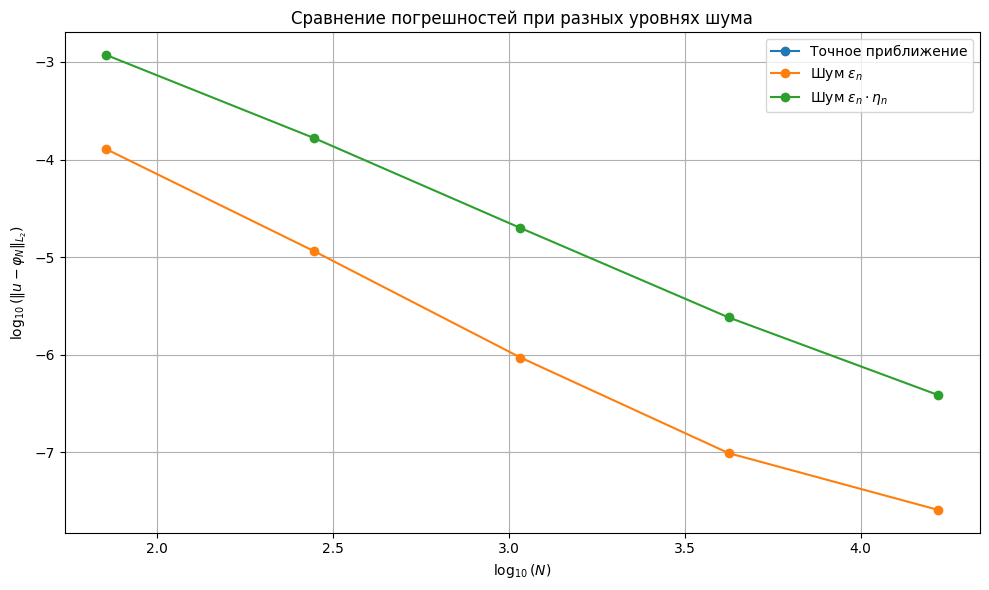

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df_t01 = df[df['t'] == 0].copy()
df_t01['logN'] = np.log10(df_t01['N'])
df_t01['log_err_exact'] = np.log10(df_t01['L2_exact'])
df_t01['log_err_eps'] = np.log10(df_t01['L2_eps'])
df_t01['log_err_eta'] = np.log10(df_t01['L2_eta'])

plt.figure(figsize=(10, 6))
plt.plot(df_t01['logN'], df_t01['log_err_exact'], 'o-', label="Точное приближение")
plt.plot(df_t01['logN'], df_t01['log_err_eps'], 'o-', label=r"Шум $\varepsilon_n$")
plt.plot(df_t01['logN'], df_t01['log_err_eta'], 'o-', label=r"Шум $\varepsilon_n \cdot \eta_n$")

plt.xlabel(r"$\log_{10}(N)$")
plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
plt.title("Сравнение погрешностей при разных уровнях шума")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Готовый модуль**

In [ ]:
def run_comparison_module(r=4, theta=1.1, s=2, t_val=0.01, eta_function=None, save_csv=False):
    results = []

    if eta_function is None:
        eta_function = lambda n: (n + 1)**1.5

    for n in range(2, 7):
        M = build_Qn(n)
        f_hat, _ = compute_hat_f(M, r, s, theta)

        eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
        eta_n = eta_function(n)

        u_ref = solution(M, f_hat, Z, t_val).cpu()

        # phi_N при точных коэффах
        phi_exact = aggregate(M, f_hat, Z, t_val).cpu()

        # при eps_n
        c_eps = add_noise(f_hat, eps_n, mode="random")
        phi_eps = aggregate(M, c_eps, Z, t_val).cpu()

        # при eps_n * eta_n
        c_eta = add_noise(f_hat, eps_n, mode="eta_scaled", eta_n=eta_n)
        phi_eta = aggregate(M, c_eta, Z, t_val).cpu()

        # ошибки
        err_exact, _ = compute_errors(u_ref, phi_exact)
        err_eps, _ = compute_errors(u_ref, phi_eps)
        err_eta, _ = compute_errors(u_ref, phi_eta)

        results.append({
            "n": n,
            "N": M.shape[0],
            "t": t_val,
            "eps_n": eps_n,
            "eta_n": eta_n,
            "L2_exact": err_exact,
            "L2_eps": err_eps,
            "L2_eta": err_eta
        })

    df = pd.DataFrame(results)
    df['logN'] = np.log10(df['N'])
    df['log_err_exact'] = np.log10(df['L2_exact'])
    df['log_err_eps'] = np.log10(df['L2_eps'])
    df['log_err_eta'] = np.log10(df['L2_eta'])

    # График
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'x-', label="Точное приближение")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=r"Шум $\varepsilon_n$")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=r"Шум $\varepsilon_n \cdot \eta_n$")
    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Погрешности для t = {t_val}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_csv:
        df.to_csv(f"errors_eta_comparison_t{t_val}.csv", index=False)
        print(f"Сохранено в errors_eta_comparison_t{t_val}.csv")

    return df


Использование:

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



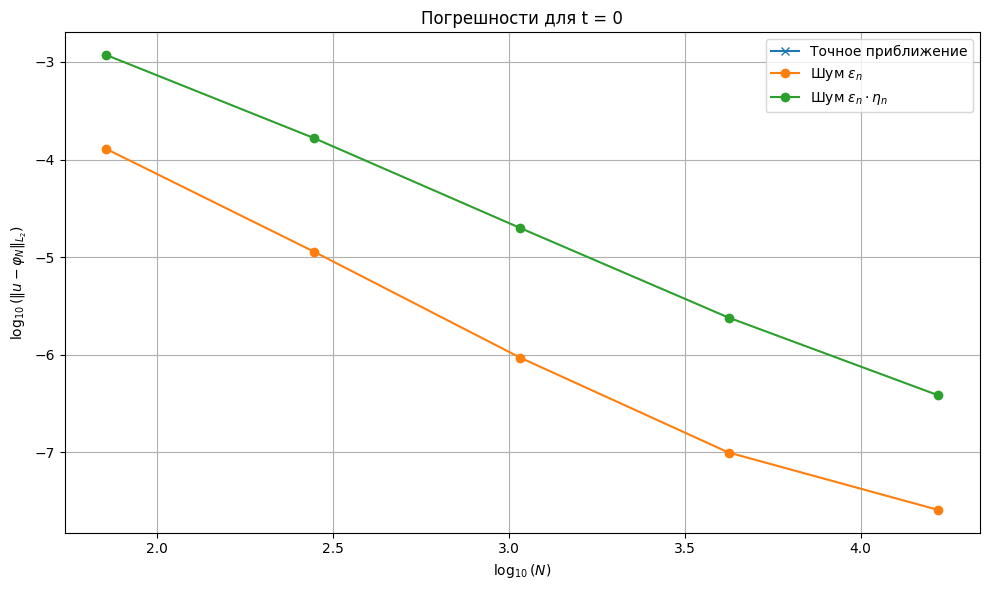

In [ ]:
# Сравнение с ηₙ = (n+1)^1.5
df_errors = run_comparison_module(r=4, theta=1.1, t_val=0, eta_function=lambda n: (n + 1)**1.5)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



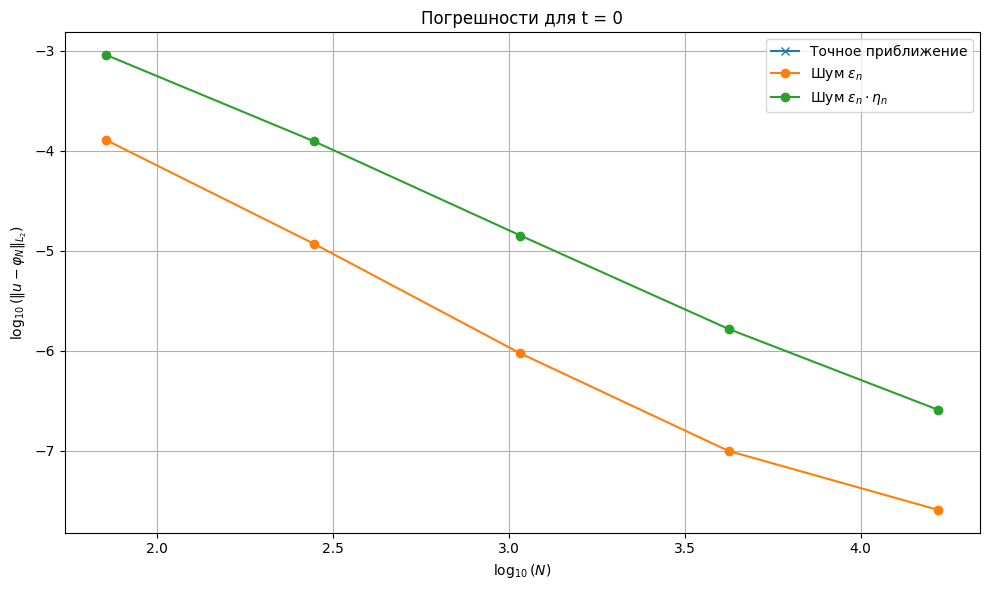

In [ ]:
df_errors = run_comparison_module(
    eta_function=lambda n: 2*n,
    t_val=0
)

✅ Добавим вычисление наклонов (порядков сходимости)
Вот расширенный модуль, который:

Вычисляет ошибки для каждого n

Строит log–log-график

Находит наклон прямой (порядок сходимости) через метод наименьших квадратов

Подписывает их на графике

### **🧩 Полный модуль**

In [ ]:
def run_comparison_with_slopes(r=4, theta=1.1, s=2, t_val=0.01, eta_function=None, save_csv=False):
    results = []

    if eta_function is None:
        eta_function = lambda n: 2**n + 1  # исправленный ηₙ

    for n in range(2, 7):
        M = build_Qn(n)
        f_hat, _ = compute_hat_f(M, r, s, theta)

        eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
        eta_n = eta_function(n)

        u_ref = solution(M, f_hat, Z, t_val).cpu()
        phi_exact = aggregate(M, f_hat, Z, t_val).cpu()

        c_eps = add_noise(f_hat, eps_n, mode="random")
        phi_eps = aggregate(M, c_eps, Z, t_val).cpu()

        c_eta = add_noise(f_hat, eps_n, mode="eta_scaled", eta_n=eta_n)
        phi_eta = aggregate(M, c_eta, Z, t_val).cpu()

        err_exact, _ = compute_errors(u_ref, phi_exact)
        err_eps, _ = compute_errors(u_ref, phi_eps)
        err_eta, _ = compute_errors(u_ref, phi_eta)

        results.append({
            "n": n,
            "N": M.shape[0],
            "t": t_val,
            "eps_n": eps_n,
            "eta_n": eta_n,
            "L2_exact": err_exact,
            "L2_eps": err_eps,
            "L2_eta": err_eta
        })

    df = pd.DataFrame(results)
    df['logN'] = np.log10(df['N'])
    df['log_err_exact'] = np.log10(df['L2_exact'])
    df['log_err_eps'] = np.log10(df['L2_eps'])
    df['log_err_eta'] = np.log10(df['L2_eta'])

    # Наклоны (по 3 прямым)
    def get_slope(x, y):
        return np.polyfit(x, y, deg=1)[0]

    slope_exact = get_slope(df['logN'], df['log_err_exact'])
    slope_eps = get_slope(df['logN'], df['log_err_eps'])
    slope_eta = get_slope(df['logN'], df['log_err_eta'])

    # График
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'o-', label=f"Точное, α = {slope_exact:.2f}")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=f"Шум εₙ, α = {slope_eps:.2f}")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=f"Шум εₙ·ηₙ, α = {slope_eta:.2f}")

    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Порядок сходимости при t = {t_val}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_csv:
        df.to_csv(f"errors_eta_slope_t{t_val}.csv", index=False)
        print(f"Таблица сохранена в errors_eta_slope_t{t_val}.csv")

    return df, slope_exact, slope_eps, slope_eta


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



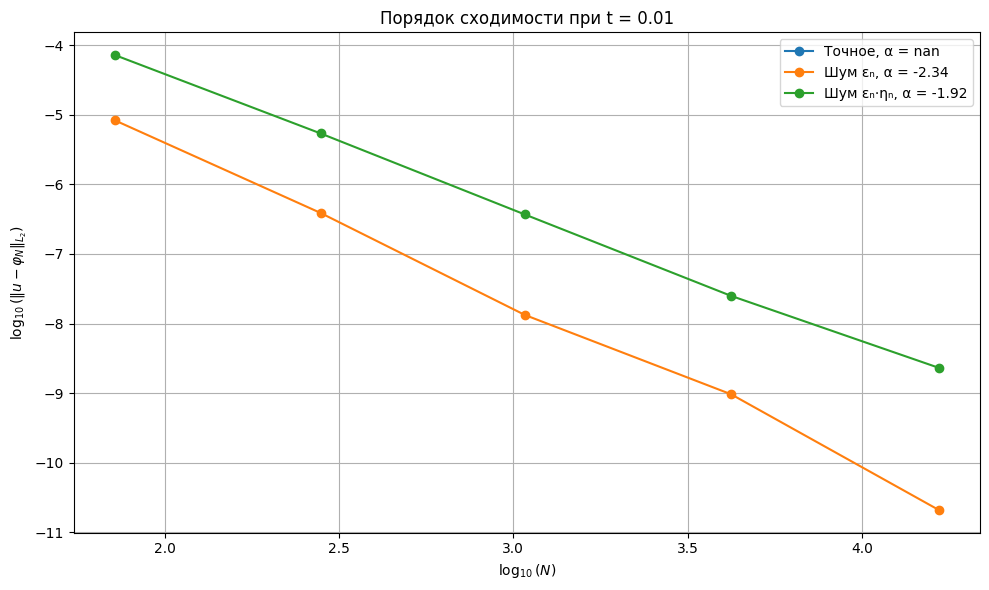

In [ ]:
df_errors, α_exact, α_eps, α_eta = run_comparison_with_slopes(t_val=0.01)

In [ ]:
def run_comparison_with_slopes(r=4, theta=1.1, s=2, t_val=0.01, eta_function=None, save_csv=False):
    results = []

    if eta_function is None:
        eta_function = lambda n: 2**n + 1  # исправленный ηₙ

    for n in range(2, 7):
        M = build_Qn(n)
        f_hat, _ = compute_hat_f(M, r, s, theta)

        eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
        eta_n = eta_function(n)

        u_ref = solution(M, f_hat, Z, t_val).cpu()
        phi_exact = aggregate(M, f_hat, Z, t_val).cpu()

        c_eps = add_noise(f_hat, eps_n, mode="random")
        phi_eps = aggregate(M, c_eps, Z, t_val).cpu()

        c_eta = add_noise(f_hat, eps_n, mode="eta_scaled", eta_n=eta_n)
        phi_eta = aggregate(M, c_eta, Z, t_val).cpu()

        err_exact, _ = compute_errors(u_ref, phi_exact)
        err_eps, _ = compute_errors(u_ref, phi_eps)
        err_eta, _ = compute_errors(u_ref, phi_eta)

        results.append({
            "n": n,
            "N": M.shape[0],
            "t": t_val,
            "eps_n": eps_n,
            "eta_n": eta_n,
            "L2_exact": err_exact,
            "L2_eps": err_eps,
            "L2_eta": err_eta
        })

    df = pd.DataFrame(results)
    df['logN'] = np.log10(df['N'])
    df['log_err_exact'] = np.log10(df['L2_exact'])
    df['log_err_eps'] = np.log10(df['L2_eps'])
    df['log_err_eta'] = np.log10(df['L2_eta'])

    # Наклоны (по 3 прямым)
    def get_slope(x, y):
        return np.polyfit(x, y, deg=1)[0]

    slope_exact = get_slope(df['logN'], df['log_err_exact'])
    slope_eps = get_slope(df['logN'], df['log_err_eps'])
    slope_eta = get_slope(df['logN'], df['log_err_eta'])
    alpha_theor = -(r/s + 0.5)

    # График
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'o-', label=f"Точное, α = {slope_exact:.2f}")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=f"Шум εₙ, α = {slope_eps:.2f}")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=f"Шум εₙ·ηₙ, α = {slope_eta:.2f}")

    # Теоретическая прямая
    x_line = np.linspace(df['logN'].min(), df['logN'].max(), 100)
    y_line = alpha_theor * x_line + df['log_err_exact'].iloc[0]  # сдвигаем по y
    plt.plot(x_line, y_line, '--', color='gray', label=f"Теоретически: α = {alpha_theor:.2f}")

    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Порядок сходимости при t = {t_val}, теоретический: α = {alpha_theor:.2f}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_csv:
        df.to_csv(f"errors_eta_slope_t{t_val}.csv", index=False)
        print(f"Таблица сохранена в errors_eta_slope_t{t_val}.csv")

    return df, slope_exact, slope_eps, slope_eta


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



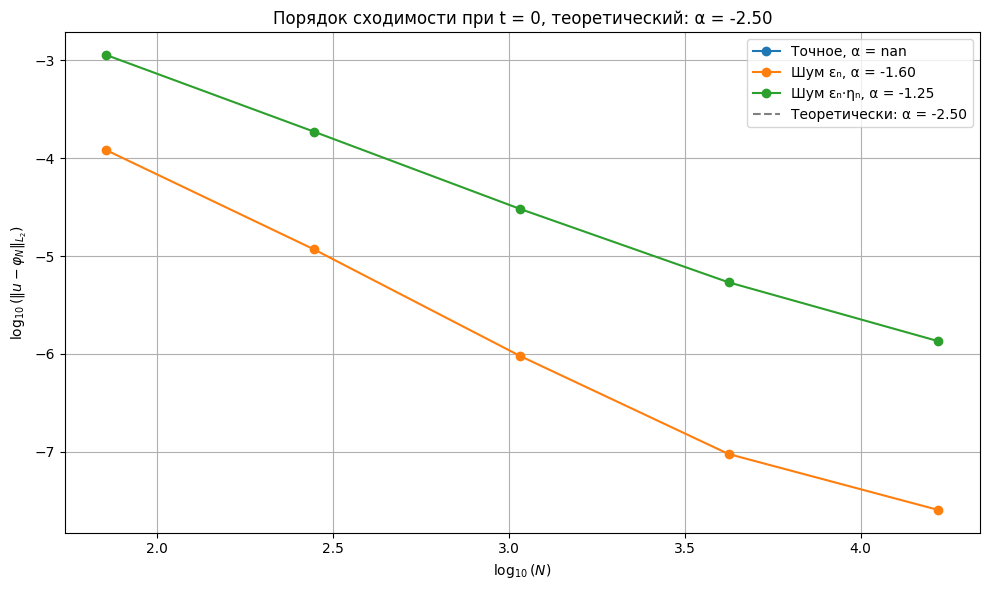

In [ ]:
df, α1, α2, α3 = run_comparison_with_slopes(r=4, theta=1.1, t_val=0)

# Полный модуль для другой функции

In [5]:
# Полный модуль: анализ сходимости аппроксимации с точной и шумной информацией

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Параметры задачи
s = 2         # размерность
r = 4         # гладкость
theta = 1.1   # второй индекс
L = 1.0       # размер области
n_max = 7    # максимальный порядок коэффициентов фурье

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Сетка по x и y
grid_points = 64
x_vals = torch.linspace(0, L, grid_points, device=device)
X, Y = torch.meshgrid(x_vals, x_vals, indexing='ij')
Z = torch.stack((X, Y), dim=-1)

# Вспомогательные функции
def get_k(m):
    abs_m = torch.maximum(torch.abs(m), torch.tensor([1], device=device))
    return torch.ceil(torch.log2(abs_m.float())).max(dim=1).values.int()

def build_Qn(n):
    grid_range = torch.arange(-2**n, 2**n + 1, device=device)
    m1, m2 = torch.meshgrid(grid_range, grid_range, indexing='ij')
    M = torch.stack((m1, m2), dim=-1).reshape(-1, 2)
    return M[torch.any(torch.abs(M) > 1, dim=1)]

def compute_hat_f1(M):
    k_vals = get_k(M)
    coeffs = 2 ** (-k_vals * (r - s/2 + 1/theta))
    return coeffs.to(torch.complex64)

def compute_hat_f(M, r=r, s=s, theta=theta):
    norm_sq = (M.float()**2).sum(dim=1)
    coeffs = 1.0 / (1 + norm_sq)**(r/2 + 1/theta)
    return coeffs.to(torch.complex64)#, get_k(M)

def aggregate(M, coeffs, Z, t):
    phase = torch.einsum('ij,xyj->ixy', M.float(), Z)
    decay = torch.exp(-4 * np.pi**2 * (M.float()**2).sum(dim=1) * t)
    terms = coeffs * decay
    cos_phase = torch.cos(2 * np.pi * phase)
    sin_phase = torch.sin(2 * np.pi * phase)
    real = torch.sum(cos_phase * terms.real[:, None, None] - sin_phase * terms.imag[:, None, None], dim=0)
    imag = torch.sum(sin_phase * terms.real[:, None, None] + cos_phase * terms.imag[:, None, None], dim=0)
    return torch.complex(real, imag)

def solution(M, coeffs, Z, t):
    return aggregate(M, coeffs, Z, t)

def add_noise(c_exact, eps_n, mode="random", eta_n=None):
    """
    Возвращает приближённые коэффициенты c̃_m = c_m + шум
    mode: "random", "systematic", "eta_scaled"
    """
    if mode == "random":
        noise_real = torch.rand_like(c_exact.real) * eps_n
        noise_imag = torch.rand_like(c_exact.imag) * eps_n
        noise = torch.complex(noise_real, noise_imag)
        return c_exact + noise

    elif mode == "systematic":
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_n),
            torch.full_like(c_exact.imag, eps_n)
        )
        return c_exact + noise

    elif mode == "eta_scaled":
        if eta_n is None:
            raise ValueError("eta_n must be specified for eta_scaled noise")
        eps_eta = eps_n * eta_n
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_eta),
            torch.full_like(c_exact.imag, eps_eta)
        )
        return c_exact + noise

    else:
        raise ValueError(f"Unknown noise mode: {mode}")


def compute_L2_error(u_exact, u_approx):
    diff = u_exact - u_approx
    return torch.sqrt((diff * torch.conj(diff)).real.mean()).item()

def compute_max_error(u_exact, u_approx):
    diff = u_exact - u_approx
    return torch.max(diff.real).item()

# Наклоны (по 3 прямым)
def get_slope(x, y):
    return np.polyfit(x, y, deg=1)[0]

# Главный модуль анализа

def run_convergence_analysis(t_val=0.01, mode="random", eta_function=None, save_csv=False):
    if eta_function is None:
        eta_function = lambda n: 2**n + 1
    results = []

    for n in range(2, 7):
        M_all = build_Qn(n_max)  # фиксированное большое множество мод
        f_hat_all = compute_hat_f(M_all)

        M_n = build_Qn(n)
        idx = torch.any((M_all[:, None, :] == M_n).all(dim=2), dim=1)
        c_n = f_hat_all[idx]

        eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
        eta_n = eta_function(n)

        u_ref = aggregate(M_all, f_hat_all, Z, t_val).cpu()

        phi_exact = aggregate(M_n, c_n, Z, t_val).cpu()
        phi_eps = aggregate(M_n, add_noise(c_n, eps_n, mode=mode), Z, t_val).cpu()
        phi_eta = aggregate(M_n, add_noise(c_n, eps_n, mode="eta_scaled", eta_n=eta_function(n)), Z, t_val).cpu()

        err_exact = compute_L2_error(u_ref, phi_exact)
        err_eps = compute_L2_error(u_ref, phi_eps)
        err_eta = compute_L2_error(u_ref, phi_eta)

        err_exact_max = compute_max_error(u_ref, phi_exact)
        err_eps_max = compute_max_error(u_ref, phi_eps)
        err_eta_max = compute_max_error(u_ref, phi_eta)

        results.append({
            "n": n,
            "N": M_n.shape[0]+9,
            "eps_n": eps_n,
            "eta_n": eta_n,
            "L2_exact": err_exact,
            "L2_eps": err_eps,
            "L2_eta": err_eta,
            "max_exact": err_exact_max,
            "max_eps": err_eps_max,
            "max_eta": err_eta_max
        })

    df = pd.DataFrame(results)
    df['logN'] = np.log10(df['N'])
    df['log_err_exact'] = np.log10(df['L2_exact'])
    df['log_err_eps'] = np.log10(df['L2_eps'])
    df['log_err_eta'] = np.log10(df['L2_eta'])
    df['log_err_exact_max'] = np.log10(df['max_exact'])
    df['log_err_eps_max'] = np.log10(df['max_eps'])
    df['log_err_eta_max'] = np.log10(df['max_eta'])


    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'x--', label="Точное")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=r"Шум $\varepsilon_n$")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=r"Шум $\varepsilon_n \cdot \eta_n$")

    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Сходимость аппроксимации в $L^2$ при t = {t_val}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact_max'], 'x--', label="Точное")
    plt.plot(df['logN'], df['log_err_eps_max'], 'o-', label=r"Шум $\varepsilon_n$")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=r"Шум $\varepsilon_n \cdot \eta_n$")

    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Сходимость аппроксимации в $L^\infty$ при t = {t_val}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    slope_exact = get_slope(df['logN'], df['log_err_exact'])
    slope_eps = get_slope(df['logN'], df['log_err_eps'])
    slope_eta = get_slope(df['logN'], df['log_err_eta'])
    alpha_theor = -(r/s + 0.5)

    # График
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'o-', label=f"Точное, α = {slope_exact:.2f}")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=f"Шум εₙ, α = {slope_eps:.2f}")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=f"Шум εₙ·ηₙ, α = {slope_eta:.2f}")

    # Теоретическая прямая
    x_line = np.linspace(df['logN'].min(), df['logN'].max(), 100)
    y_line = alpha_theor * x_line + df['log_err_exact'].iloc[0]  # сдвигаем по y
    plt.plot(x_line, y_line, '--', color='gray', label=f"Теоретически: α = {alpha_theor:.2f}")

    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Порядок сходимости при t = {t_val}, теоретический: α = {alpha_theor:.2f}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_csv:
        df.to_csv(f"errors_eta_slope_t{t_val}.csv", index=False)
        print(f"Таблица сохранена в errors_eta_slope_t{t_val}.csv")

    return df, slope_exact, slope_eps, slope_eta

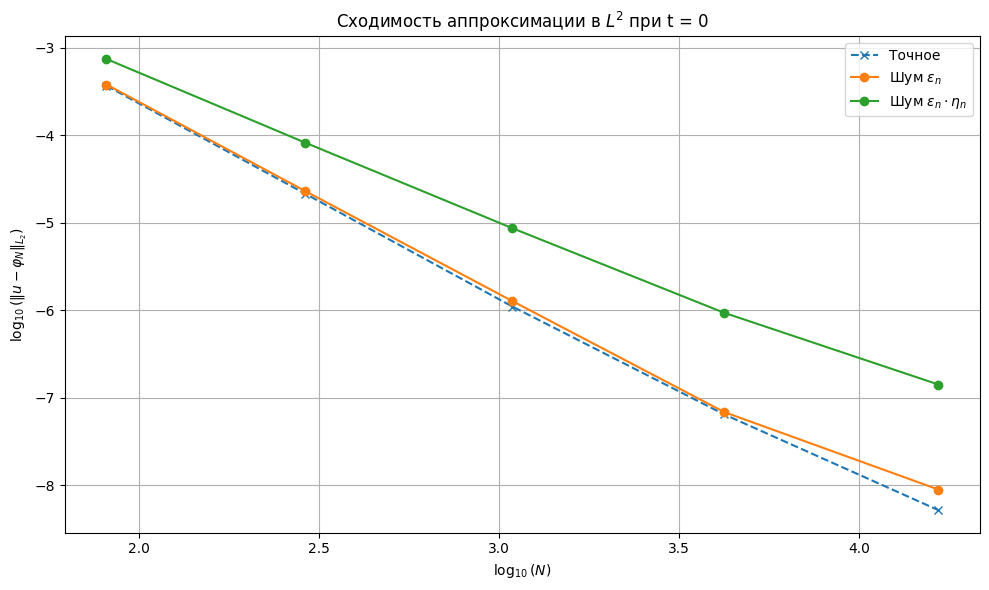

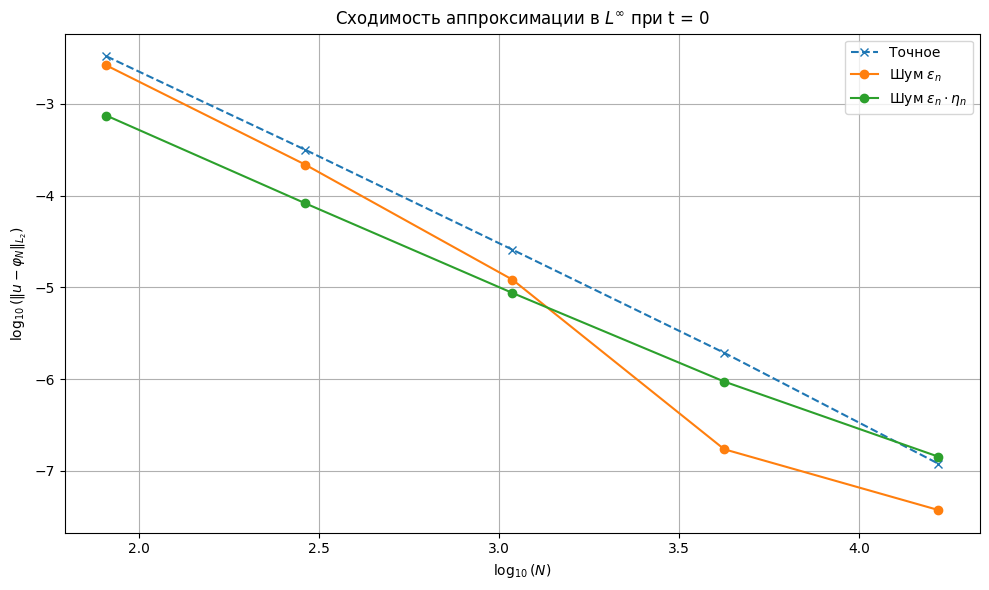

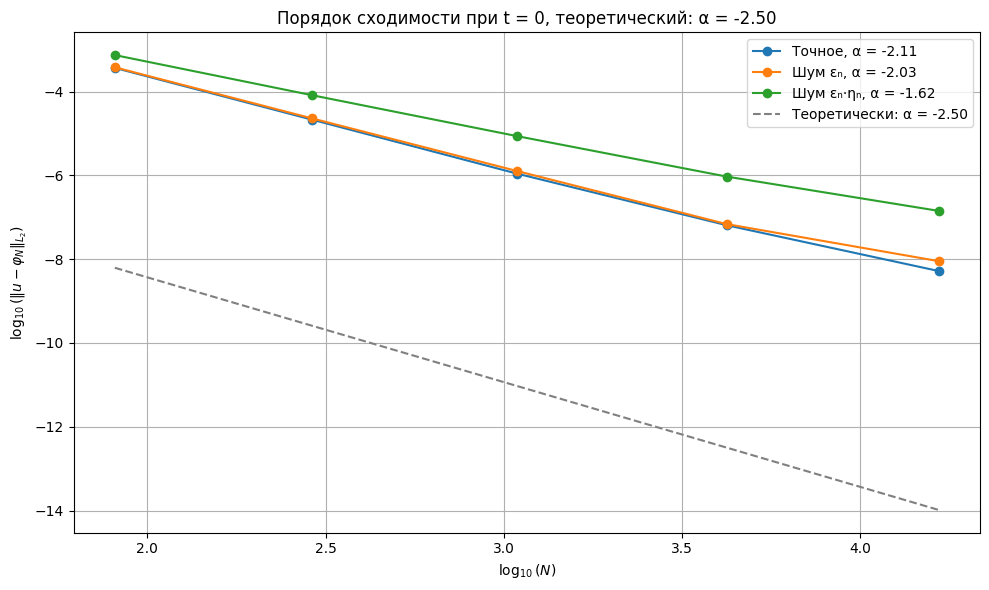

In [6]:
df, α1, α2, α3  = run_convergence_analysis(t_val=0, mode = "random", eta_function = lambda n: n + 1)

In [7]:
 df[['n','N','eps_n', 'L2_exact', 'L2_eps','L2_eta']]

,n,N,eps_n,L2_exact,L2_eps,L2_eta
0,2,81,1.693509e-05,3.687152e-04,3.809466e-04,7.454936e-04
1,3,289,7.042963e-07,2.154965e-05,2.309643e-05,8.253381e-05
2,4,1089,2.555232e-08,1.105406e-06,1.275540e-06,8.680455e-06
3,5,4225,8.618530e-10,6.473712e-08,6.883524e-08,9.378825e-07
4,6,16641,2.799313e-11,5.213664e-09,8.970818e-09,1.421841e-07
